In [1529]:
import numpy as np 
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns 
import graphviz 
import cairosvg

from IPython.display import display, IFrame
RANDOM_SEED = 20
np.random.seed(RANDOM_SEED)

In [1530]:
def bipartite_layout(inputG, LR=True):
    ## bipartite한 graph의 layout
    if nx.is_bipartite(inputG) and nx.is_connected(inputG):## connected and bipartite
        bs1, bs2 = nx.bipartite.sets(inputG)
        bs1 = sorted(bs1, key=lambda x: x, reverse=True)
        bs2 = sorted(bs2, key=lambda x: x, reverse=True)
        pos = {}
        if LR==True:
            pos.update({n:(0, 1.0/(len(bs1)+1)*(i+1)) for i, n in enumerate(bs1)})
            pos.update({n:(1, 1.0/(len(bs2)+1)*(i+1)) for i, n in enumerate(bs2)})
        else:
            pos.update({n:(1.0 - 1.0/(len(bs1)+1)*(i+1), 1) for i, n in enumerate(bs1)})
            pos.update({n:(1.0 - 1.0/(len(bs2)+1)*(i+1), 0) for i, n in enumerate(bs2)})
        return pos
    else:# 이 경우 none을 리턴하므로, default layout으로 그림이 그려지게 됩니다. 
        print("it is not bipartite and not connected")

def make_deg_seq(deg_sum, seq_a_len, max_deg):
    ## deg_sum에 맞도록 degree dist를 랜덤하게 분포함
    ## max_deg는 한 node가 가질 수 있는 최대 degree, 여기서는 multi graph가 아닌 graph로 가정 
    ## partition을 이용해서 만드는 방법도 해봤지만, 속도 문제가 너무 큼, 당연한것이 아래는 단 하나의 조건만을 만드는 경우, 
    ## partition을 이용하면, 모든 종류를 다 만드는 경우 
    if deg_sum > (seq_a_len*max_deg):
        print("deg_sum is too large")
    elif deg_sum < seq_a_len or deg_sum < max_deg:
        print("deg_sum is too small")
    else: 
        seq_a = [1 for i in range(0, seq_a_len)]
        remain_seq_a = deg_sum - seq_a_len
        while remain_seq_a>0:
            idx = np.random.choice(seq_a_len)
            if seq_a[idx]+1<=max_deg:
                seq_a[idx]+=1
                remain_seq_a-=1
        return seq_a

In [1537]:
#np.random.seed(RANDOM_SEED)
def make_balanced_random_tree(node_size, branching, height):
    np.random.seed(RANDOM_SEED)
    ## 최대 branching의 수, height를 정하고, node_size만큼의 tree를 만듭니다. 
    bg = nx.balanced_tree(branching, height-1)
    if len(bg.nodes()) < node_size:
        print("len(bg.nodes()) < node_size")
    bg.remove_nodes_from(list(bg.nodes())[node_size:])# 정해진 node의 수를 넘는 노드는 다 삭제 
    level_node = [[0], ]## 레벨별로 들어가야 하는 노드를 리스트로 넣어둠 
    for i in range(0, height-1):
        left, right = sum([branching**j for j in range(0, i+1)]), sum([branching**(j+1) for j in range(0, i+1)])
        level_node.append([k for k in range(left, right+1)])
    ## make it random: 임의로 선을 바꿈 
    for i in range(1, len(level_node)-1):
        for j in range(0, 100):
            edges = [e for e in bg.edges() if e[0] in level_node[i] and e[1] in level_node[i+1]]
            r_e = edges[np.random.randint(0, len(edges))]
            bg.remove_edge(r_e[0], r_e[1]), bg.add_edge(np.random.choice(level_node[i]), r_e[1])
    return bg
"""
bg = make_balanced_random_tree(20, 3, 4)
pos=nx.drawing.nx_agraph.graphviz_layout(bg, prog='dot')
plt.figure(figsize=(15, 6))
nx.draw_networkx(bg, pos)
plt.show()"""

"\nbg = make_balanced_random_tree(20, 3, 4)\npos=nx.drawing.nx_agraph.graphviz_layout(bg, prog='dot')\nplt.figure(figsize=(15, 6))\nnx.draw_networkx(bg, pos)\nplt.show()"

In [1538]:
## draw process 
## 이후에 이 아이는 좀 더 손볼 필요가 있음. 
## 지금은 business process가 비교적 단순한 형태지만 복잡할 때는 어떻게 할 것인가? 
def activity_lst_to_png(activity_lst, output_file_name):
    def save_graph_as_svg(dot_string, output_file_name):
        if type(dot_string) is str:## dot language string으로 들어올 때, 
            g = graphviz.Source(dot_string)
        elif isinstance(dot_string, (graphviz.dot.Digraph, graphviz.dot.Graph)):## 객체로 들어올 때 
            g = dot_string
        else:
            print("can't handle it"), 
            return None
        ### outputfile 
        g.filename, g.format = output_file_name.split('.')[0], 'svg'
        g.directory = '../../assets/images/markdown_img/'
        g.render(view=False)
        ## svg to png, requried import cairosvg
        if output_file_name.split('.')[1]=='png':
            cairosvg.svg2png(url=g.directory+g.filename+"."+'svg',
                             write_to=g.directory+output_file_name, dpi = 200)
        return g
    activity_lst = ["Source"]+activity_lst+['Sink']
    BP = graphviz.Digraph(comment='business process')
    BP.graph_attr['rankdir'] = 'LR'
    ## add node 
    for i, act in enumerate(activity_lst):
        if act in ['Source', 'Sink']: ## 처음이거나 끝일 때는 노드를 다르게 표시 
            BP.node(act, shape="doublecircle", color='red') if act=='Source' else BP.node(act, shape="doublecircle", color='blue')
        else:
            BP.node(act, shape='rectangle')
    ## add edge 
    for i in range(0, len(activity_lst)-1):
        BP.edge(activity_lst[i], activity_lst[i+1])
    save_graph_as_svg(BP, output_file_name)
    return BP

class Activity(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist# (min, max, mode)
    def __repr__(self):
        return self.name
    
class Resource(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist
    def __repr__(self):
        return self.name

In [1541]:
#np.random.seed(RANDOM_SEED)

## resource와 activity를 bipartite한 네트워크로 구성하고, 
## activity를 수행해야 할 때는 일단 해당 activity를 수행할 수 있는 사람셋을 해당 네트워크를 통해서 찾음 
## 액티비티 종료 후 
#act_resource_network = nx.Graph()


##### setting
## 여기서 각 A_set와 R_set를 만들어 준다. 
A_set = [Activity('A{:0>2d}'.format(i), (1, 3, 5)) for i in range(0, 5)]
R_set = [Resource('R{:0>2d}'.format(i), (1, 2, 3)) for i in range(0, 20)]
#########################

In [1542]:
def make_R_A_net(input_A_set, input_R_set):
    # A_set, R_set으로부터 bipartite network를 구성한다. 
    deg_sum = len(input_R_set)*len(input_A_set)*0.4//1.0
    r_R_A_net = nx.bipartite.havel_hakimi_graph(make_deg_seq(deg_sum, len(input_R_set), len(input_A_set)), 
                                              make_deg_seq(deg_sum, len(input_A_set), len(input_R_set)))
    ## update type attribute
    mapping = {}
    for i, n in enumerate([n[0] for n in r_R_A_net.nodes(data=True) if n[1]['bipartite']==0]):
        r_R_A_net.nodes[n]['type']='Resource' ## for relabeling 
        r_R_A_net.nodes[n]['Resource']=input_R_set[i]
        mapping[n] = input_R_set[i].name
    for i, n in enumerate([n[0] for n in r_R_A_net.nodes(data=True) if n[1]['bipartite']==1]):
        r_R_A_net.nodes[n]['type']='Activity'
        r_R_A_net.nodes[n]['Activity']=input_A_set[i]
        mapping[n] = input_A_set[i].name
    return nx.relabel_nodes(r_R_A_net, mapping)
## make R_net 
def make_R_net(input_R_set):
    # 입력받은 R_set으로부터 random한 tree를 만들고 리턴
    r_R_net = make_balanced_random_tree(len(input_R_set), 3, 4)
    for n, r in zip(r_R_net.nodes(), np.random.choice(input_R_set, len(input_R_set), replace=False)):
        r_R_net.nodes[n]['Resource'] = r
    return nx.relabel_nodes(r_R_net, mapping = {n[0]:n[1]['Resource'].name for n in r_R_net.nodes(data=True)})

In [1543]:
#activity_lst_to_png([a.name for a in A_set], 'sequential_bp.png')
R_A_net = make_R_A_net(A_set, R_set)
R_net = make_R_net(R_set)

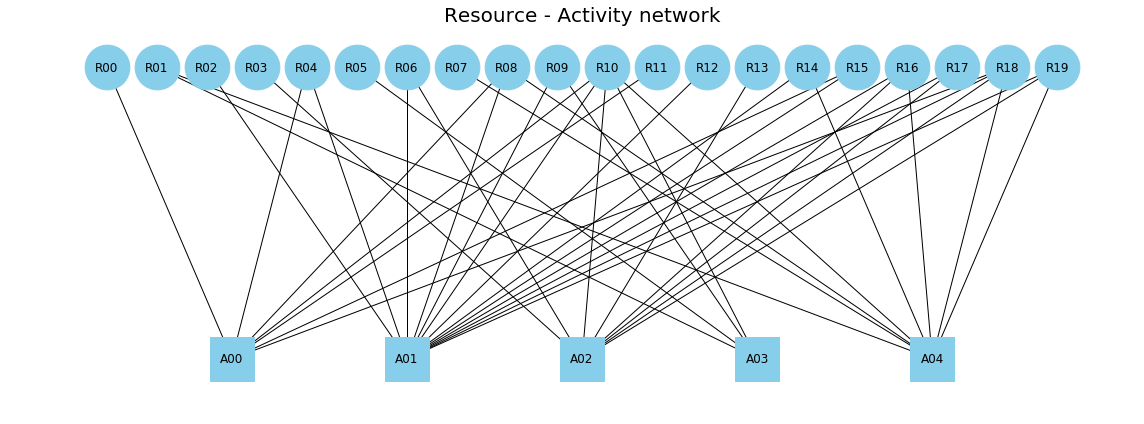

In [1546]:
for s in nx.bipartite.sets(R_A_net):
    degs = sorted([x[1] for x in R_A_net.degree(s)], reverse=True)
    #print(degs), print("-"*40)

plt.figure(figsize=(16, 6))
pos = bipartite_layout(R_A_net, LR=False)
nx.draw_networkx(R_A_net, pos=pos, node_size=200, node_color='skyblue')
nx.draw_networkx_nodes(R_A_net, pos=pos, nodelist=nx.bipartite.sets(R_A_net)[0], node_shape='o',
                       node_size=2000, node_color='skyblue')
nx.draw_networkx_nodes(R_A_net, pos=pos, nodelist=nx.bipartite.sets(R_A_net)[1], node_shape='s',
                       node_size=2000, node_color='skyblue')

#nx.draw_networkx(R_net, pos=tree_position(R_net), node_size=2000, node_color='skyblue', ax = axes[1])
plt.axis('off')
plt.title('Resource - Activity network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
## degree dist check
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_RA_net.png', dpi=200)
plt.show()

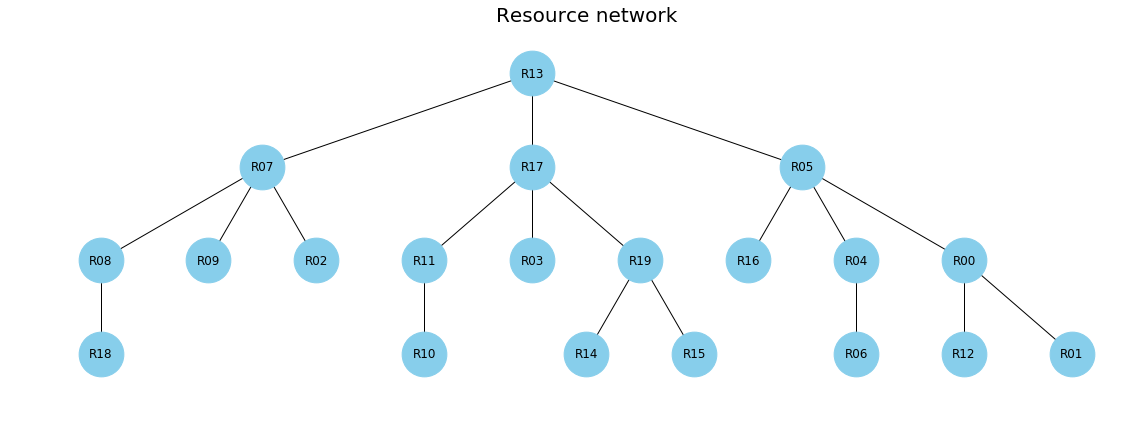

In [1548]:
plt.figure(figsize=(16, 6))
pos = nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}

nx.draw_networkx(R_net, pos=new_pos, node_size=2000, node_color='skyblue')
plt.axis('off')
plt.title('Resource network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.show()

## log generation 

- 여기서는 log를 만들어줍니다. 
- 여기도 함수로 변경해줘야될것 같은데. 

In [1336]:
log_df = [] ## log 
np.random.seed(RANDOM_SEED)
def process(env, process_name, activity_lst, human_store, input_R_net):
    ## print('<{}> start                at {:8.2f}'.format(process_name, env.now))
    ## process의 activity를 수행할 리소스 조합을 찾음
    resource_lst = [np.random.choice(list(R_A_net.neighbors(act.name))) for act in activity_lst]
    for i, act_r in enumerate(zip(activity_lst, resource_lst)):
        act, r = act_r
        left, mode, right = act.t_dist 
        r_resource = yield human_store.get(lambda x: True if x.name == r else False )
        ## (process_name, activity_name, resource, start or end, timestamp)
        log_df.append( (process_name, act.name, r_resource.name, 'start', env.now) )
        ## print("<{}> {} start by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        execution_time = np.random.triangular(left=left, right=right, mode=mode)
        yield env.timeout(execution_time)
        yield human_store.put(r_resource)
        ## print("<{}> {}   end by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        log_df.append( (process_name, act.name, r_resource.name, 'end', env.now) )
        ## 마지막 액티비티는 tranfer of work이 발생하지 않으므로 멈춤
        if (i+1)==len(activity_lst):
            break
        else:## 여기서는 transfer of work이 있으므로 일을 조직구조에 따라서 일을 전달함. 
            next_act, next_r = activity_lst[i+1], resource_lst[i+1]
            transfer_path = nx.shortest_path(input_R_net, r, next_r)
            if len(transfer_path)==1: ## 같은 사람에게 배정되었으므로 transfer of work이 없고 바로 올라감
                continue
            for j in range(0, len(transfer_path[1:-1])):
                ## edge time 
                ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[j], transfer_path[j+1], env.now))
                yield env.timeout(np.random.triangular(1, 2, 3)) 
                ## print('<{}> {} execute transfer at {:6.2f}'.format(process_name, transfer_path[j+1], env.now))
                ## node time
                transfer_r = yield human_store.get(lambda x: True if x.name == r else False )
                yield env.timeout(np.random.triangular(*transfer_r.t_dist)) ## node time 
                yield human_store.put(transfer_r)
            ## edge time
            ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[-2], transfer_path[-1], env.now))
            yield env.timeout(np.random.triangular(1, 2, 3))
            ## print("<{}> transfer end         at {:6.2f}".format(process_name, env.now))
    ## print('<{}> end                  at {:8.2f}'.format(process_name, env.now))
    return None

def process_generator(env, activity_set, resource_set, input_R_net, process_size):
    ## 주기적으로 process 를 env에 등록함 
    human_store = simpy.FilterStore(env)
    human_store.items = [r for r in resource_set]
    for i in range(0, process_size):
        yield env.timeout(np.random.triangular(1, 3, 5))
        ## 만약 activity-set에 약간 랜덤성을 부여하고 싶을 경우, 여기서 activity-set를 알아서 조절해서 넘김 
        ## 예를 들어서, exclusive하게 process 의 activity 조합이 만들어진 경우에는 활률적으로 activity를 조절하여 넘김 
        env.process(
            process(env=env, 
                    process_name = 'Process{:0>5d}'.format(i), 
                    activity_lst = activity_set, human_store = human_store, 
                    input_R_net = input_R_net
                   )
        )
        
###########
env = simpy.Environment()
env.process(process_generator(env, A_set, R_set, input_R_net=R_net, process_size=3000))
env.run()
print('complete')

complete


In [1556]:
def log_generation(input_R_set, input_A_set, input_R_net, process_size=3000):
    log_df = [] ## log 
    np.random.seed(RANDOM_SEED)
    def process(env, process_name, activity_lst, human_store, input_R_net):
        ## print('<{}> start                at {:8.2f}'.format(process_name, env.now))
        ## process의 activity를 수행할 리소스 조합을 찾음
        resource_lst = [np.random.choice(list(R_A_net.neighbors(act.name))) for act in activity_lst]
        for i, act_r in enumerate(zip(activity_lst, resource_lst)):
            act, r = act_r
            left, mode, right = act.t_dist 
            r_resource = yield human_store.get(lambda x: True if x.name == r else False )
            ## (process_name, activity_name, resource, start or end, timestamp)
            log_df.append( (process_name, act.name, r_resource.name, 'start', env.now) )
            ## print("<{}> {} start by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
            execution_time = np.random.triangular(left=left, right=right, mode=mode)
            yield env.timeout(execution_time)
            yield human_store.put(r_resource)
            ## print("<{}> {}   end by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
            log_df.append( (process_name, act.name, r_resource.name, 'end', env.now) )
            ## 마지막 액티비티는 tranfer of work이 발생하지 않으므로 멈춤
            if (i+1)==len(activity_lst):
                break
            else:## 여기서는 transfer of work이 있으므로 일을 조직구조에 따라서 일을 전달함. 
                next_act, next_r = activity_lst[i+1], resource_lst[i+1]
                transfer_path = nx.shortest_path(input_R_net, r, next_r)
                if len(transfer_path)==1: ## 같은 사람에게 배정되었으므로 transfer of work이 없고 바로 올라감
                    continue
                for j in range(0, len(transfer_path[1:-1])):
                    ## edge time 
                    ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[j], transfer_path[j+1], env.now))
                    yield env.timeout(np.random.triangular(1, 2, 3)) 
                    ## print('<{}> {} execute transfer at {:6.2f}'.format(process_name, transfer_path[j+1], env.now))
                    ## node time
                    transfer_r = yield human_store.get(lambda x: True if x.name == r else False )
                    yield env.timeout(np.random.triangular(*transfer_r.t_dist)) ## node time 
                    yield human_store.put(transfer_r)
                ## edge time
                ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[-2], transfer_path[-1], env.now))
                yield env.timeout(np.random.triangular(1, 2, 3))
                ## print("<{}> transfer end         at {:6.2f}".format(process_name, env.now))
        ## print('<{}> end                  at {:8.2f}'.format(process_name, env.now))
        return None

    def process_generator(env, activity_set, resource_set, input_R_net, process_size):
        ## 주기적으로 process 를 env에 등록함 
        human_store = simpy.FilterStore(env)
        human_store.items = [r for r in resource_set]
        for i in range(0, process_size):
            yield env.timeout(np.random.triangular(1, 3, 5))
            ## 만약 activity-set에 약간 랜덤성을 부여하고 싶을 경우, 여기서 activity-set를 알아서 조절해서 넘김 
            ## 예를 들어서, exclusive하게 process 의 activity 조합이 만들어진 경우에는 활률적으로 activity를 조절하여 넘김 
            env.process(
                process(env=env, 
                        process_name = 'Process{:0>5d}'.format(i), 
                        activity_lst = activity_set, human_store = human_store, 
                        input_R_net = input_R_net
                       )
            )

    ###########
    env = simpy.Environment()
    env.process(process_generator(env, input_A_set, input_R_set, input_R_net, process_size=process_size))
    env.run()
    print('complete')
    return pd.DataFrame(log_df, columns = ['process', 'activity', 'resource', 'start_end', 'timestamp'])
df = log_generation(R_set, A_set, R_A_net, 500)

complete


## simulation by log 

- 시뮬레이션을 통해서 log를 만들어 줍니다. 

In [1557]:
## simulation by log 

def process_discovery(input_df):
    ## 원래는 exclusive하게 운영되는지도 파악해야 함 
    return sorted(set(input_df['activity']))

def R_A_net_discovery(input_df):
    rG = nx.Graph()
    for a, r in set(zip(list(input_df['activity']), list(input_df['resource']))):
        rG.add_nodes_from([(r, {'bipartite':0, 'type':'Resource'}), (a, {'bipartite':1, 'type':'Activity'})])
        rG.add_edge(a, r)
    return rG

def find_mode(input_lst):
    ## mode를 찾아주는 함수
    ma, mi = max(input_lst), min(input_lst)
    bin_size = np.round(1+3.322*np.log10(len(input_lst)))## 최적의 binsize를 찾는 계산법 
    r_lst = ((x-mi)/(ma-mi) for x in input_lst)
    r_lst = (x//(1/(bin_size))/(bin_size) for x in r_lst)
    r_dict = {} ## collection Counter를 쓸 수도 있지만, 없이 하는게 더 의존성을 줄이고 좋을 것 같았음
    for k in (x*(ma-mi)+mi for x in r_lst):
        r_dict[k] = r_dict[k]+1 if k in r_dict.keys() else 1
    return sorted(r_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

def find_activity_dist(input_df):
    ## log df에서 그룹핑하여, 액티비티별로 triangular dist를 찾아서 리턴해준다. 
    activity_duration_dict = {k:[] for k in set(df['activity'])}
    for g in df.groupby(['process', 'activity']):# g[0] ==> (process, activity)
        duration = g[1]['timestamp'].iloc()[1] - g[1]['timestamp'].iloc()[0]
        activity_duration_dict[g[0][1]].append(duration)
    r_dict = {k:(np.min(v), find_mode(v), np.max(v))  for k, v in sorted(activity_duration_dict.items(), key=lambda x: x[0])}
    return r_dict

def process_gen_dist(input_df):
    ## process 가 어느 정도 주기로 발생하는지를 등록함. 
    process_gen_lst = sorted([np.min(p[1]['timestamp']) for p in input_df.groupby('process')])
    process_gen_lst = [process_gen_lst[i+1] - process_gen_lst[i] for i in range(0, len(process_gen_lst)-1)]
    return np.min(process_gen_lst), find_mode(process_gen_lst), np.max(process_gen_lst)

def process_simulation_by_log(input_df, input_R_net):
    np.random.seed(RANDOM_SEED)
    def process(env, process_name, activity_lst, human_store, input_R_A_net, input_R_net, output_df):
        ## print('<{}> start                at {:8.2f}'.format(process_name, env.now))
        ## process의 activity를 수행할 리소스 조합을 찾음
        resource_lst = [np.random.choice(list(input_R_A_net.neighbors(act.name))) for act in activity_lst]
        for i, act_r in enumerate(zip(activity_lst, resource_lst)):
            act, r = act_r
            left, mode, right = act.t_dist 
            r_resource = yield human_store.get(lambda x: True if x.name == r else False )
            ## (process_name, activity_name, resource, start or end, timestamp)
            output_df.append( (process_name, act.name, r_resource.name, 'start', env.now) )
            ##print("<{}> {} start by {}     at {:6.2f}".format(process_name, act.name, r_resource, env.now))
            execution_time = np.random.triangular(left=left, right=right, mode=mode)
            yield env.timeout(execution_time)
            yield human_store.put(r_resource)
            ##print("<{}> {}   end by {}     at {:6.2f}".format(process_name, act.name, r_resource, env.now))
            output_df.append( (process_name, act.name, r_resource.name, 'end', env.now) )
            ## 마지막 액티비티는 tranfer of work이 발생하지 않으므로 멈춤
            if (i+1)==len(activity_lst):
                break
            else:## 여기서는 transfer of work이 있으므로 일을 조직구조에 따라서 일을 전달함. 
                next_act, next_r = activity_lst[i+1], resource_lst[i+1]
                transfer_path = nx.shortest_path(input_R_net, r, next_r)
                if len(transfer_path)==1: ## 같은 사람에게 배정됨 
                    break
                for j in range(0, len(transfer_path[1:-1])):
                    ## edge time 
                    ##print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[j], transfer_path[j+1], env.now))
                    yield env.timeout(np.random.triangular(1, 2, 3)) 
                    ##print('<{}> {} execute transfer at {:6.2f}'.format(process_name, transfer_path[j+1], env.now))
                    ## node time
                    transfer_r = yield human_store.get(lambda x: True if x.name == r else False )
                    yield env.timeout(np.random.triangular(*transfer_r.t_dist)) ## node time 
                    yield human_store.put(transfer_r)
                ## edge time
                ##print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[-2], transfer_path[-1], env.now))
                yield env.timeout(np.random.triangular(1, 2, 3))
                ##print("<{}> transfer end         at {:6.2f}".format(process_name, env.now))
        ## print('<{}> end                  at {:8.2f}'.format(process_name, env.now))
        return None
    def process_generator(env, process_gen_dist_v, input_R_A_net, activity_set, resource_set, output_df, process_size):
        ## 주기적으로 process 를 env에 등록함 
        human_store = simpy.FilterStore(env)
        human_store.items = [r for r in resource_set]
        for i in range(0, process_size):
            yield env.timeout(np.random.triangular(*process_gen_dist_v))
            ## 만약 activity-set에 약간 랜덤성을 부여하고 싶을 경우, 여기서 activity-set를 알아서 조절해서 넘김 
            ## 예를 들어서, exclusive하게 process 의 activity 조합이 만들어진 경우에는 활률적으로 activity를 조절하여 넘김 
            env.process(
                process(env=env, 
                        process_name = 'Process{:0>5d}'.format(i), 
                        input_R_A_net = input_R_A_net, 
                        activity_lst = activity_set, human_store = human_store, 
                        input_R_net = input_R_net, output_df = output_df
                       )
            )
    R_A_net_disco = R_A_net_discovery(input_df)
    activity_lst = process_discovery(input_df)
    act_dist_dict = find_activity_dist(input_df)
    process_gen_dist_v = process_gen_dist(input_df)
    
    A_set = [Activity(act, act_dist_dict[act]) for act in activity_lst ]
    R_set = [Resource(r, (0, 1, 2)) for r in sorted(set(df['resource']))]

    r_df = []
    np.random.seed(RANDOM_SEED) ###
    env = simpy.Environment()
    env.process(process_generator(env, process_gen_dist_v = process_gen_dist_v, 
                                  input_R_A_net = R_A_net_disco, 
                                  activity_set=A_set, resource_set=R_set, 
                                  output_df = r_df, process_size=1000))
    env.run()
    return pd.DataFrame(r_df, columns = ['process', 'activity', 'resource', 'start_end', 'timestamp'])

In [1394]:
def find_root(inputG):
    """
    tree를 입력받아서 diameter를 기준으로 중간의 node를 root로 인식합니다. 
    만약 diameter가 균등하게 나누어지지 않을 경우에는 betweenness를 중심으로 root를 찾습니다. 
    input: tree
    output: 
    """
    if nx.is_tree(inputG):
        if nx.diameter(inputG)%2==0:
            sp_lst = (nx.shortest_path(inputG, n1, n2) for n1 in inputG.nodes() for n2 in inputG.nodes)
            sp_lst = (sp for sp in sp_lst if nx.diameter(inputG)==(len(sp)-1)) 
            sp = next(sp_lst)
            return sp[len(sp)//2]
        else: ## between
            return sorted(nx.betweenness_centrality(R_net_alt).items(), key=lambda x: x[1], reverse=True)[0][0]
    else:
        print("inputG is not tree")
def find_node_level(inputG):
    ## root를 찾고 root에서부터의 거리를 레벨로 인식하고 나열함 
    """
    input: tree graph 
    output: dictionary(key: level, value: node list)
    """
    root = find_root(inputG)
    r_dict = {}
    for n in inputG.nodes():
        l = nx.shortest_path_length(inputG, root, n)
        if l in r_dict.keys():
            r_dict[l].append(n)
        else:
            r_dict[l] = [n]
    return r_dict
def find_parent(inputG, target_node):
    ## target_node의 부모를 찾아서 리턴해준다. 
    root = find_root(inputG)
    if root == target_node:
        return None ## root node 
    else:
        target_node_level = nx.shortest_path_length(inputG, root, target_node)
        for n in inputG.neighbors(target_node):
            if (target_node_level-1)==nx.shortest_path_length(inputG, root, n):
                return n
        print("error occurred")
def find_children(inputG, target_node):
    ## target_node의 자식을 찾아서 리턴해준다. 
    root = find_root(inputG)
    if root == target_node:
        print('it is root')
    else:
        target_node_level = nx.shortest_path_length(inputG, root, target_node)
        children_node = []
        for n in inputG.neighbors(target_node):
            if (target_node_level+1)==nx.shortest_path_length(inputG, root, n):
                children_node.append(n)
        return children_node
    
def return_R_R_matrix(input_df):
    ## R, R간의 빈도, 시간 등을 고려해서 병목점을 찾음 
    r_columns = sorted(set(input_df['resource']))
    R_R_matrix = {
        'frequency': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns), 
        'time_sum': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns)
    }
    for g in input_df.groupby('process'):
        sub_df = g[1].iloc()[1:-1]
        for i in range(0, len(sub_df), 2):
            from_series, to_series = sub_df.iloc()[i], sub_df.iloc()[i+1]
            if from_series.resource != to_series.resource:## 같을 때는 transfer of work이 아님.       
                R_R_matrix['frequency'][from_series.resource][to_series.resource] += 1
                R_R_matrix['time_sum'][from_series.resource][to_series.resource] += (to_series['timestamp'] - from_series['timestamp'])
    R_R_matrix['average_time'] = (R_R_matrix['time_sum']/ R_R_matrix['frequency']).fillna(0)
    return R_R_matrix
def render_nxG_to_graphviz(inputG):
    rG = graphviz.Graph()
    rG.graph_attr.update(size="12,2")## resize
    for e in inputG.edges():
        rG.node(e[0]), rG.node(e[1])
        rG.edge(e[0], e[1])
    """
    g_graphviz.format='svg'
    g_graphviz.filename = "180822_g_graphviz"
    g_graphviz.directory = '../../assets/images/markdown_img/'
    """
    rG.format = "svg"
    rG.render(view=False)## rG.filename+'.'+rG.format 에 파일을 저장합니다. 
    return rG

In [1558]:
def return_r_r_time_lst(input_df):
    r_dict = {}
    for i, g in enumerate(input_df.groupby('process')):
        sub_df = g[1].sort_values('timestamp')
        sub_sub_df = sub_df.iloc()[1:-1]
        for i in range(0, len(sub_sub_df), 2):
            from_r, to_r = sub_sub_df.iloc()[i][['resource', 'timestamp']], sub_sub_df.iloc()[i+1][['resource', 'timestamp']]
            if from_r['resource'] in r_dict.keys():
                if to_r['resource'] in r_dict[from_r['resource']].keys():
                    r_dict[from_r['resource']][to_r['resource']] += to_r['timestamp'] - from_r['timestamp']
                else: 
                    r_dict[from_r['resource']][to_r['resource']] = to_r['timestamp'] - from_r['timestamp']
            else: 
                r_dict[from_r['resource']] = {to_r['resource']: to_r['timestamp'] - from_r['timestamp']}
    r_r_lst = ( (k1, k2, v) for k1, v_dict in r_dict.items() for k2, v in v_dict.items() )
    r_r_lst = filter(lambda x: True if x[0]!=x[1] else False, r_r_lst)
    return sorted(r_r_lst, key=lambda x: x[2], reverse=True)

def R_net_alternative_discovery(input_df, input_R_net, epochs=5):
    """
    R_net을 입력받고, time 관점에서 가장 큰 과부하가 걸리는 지점을 찾아서 그 edge가 연결되어 있지 않을 경우 연결된 R_net을 리턴함
    epoch마다 가장 좋은 놈만 남기고 다음 epoch에서 가장 과부하가 걸리는 지점을 찾는 일을 반복함
    이 경우, 탐색 영역이 매우 제한적이라서 오래 탐색을 해도 비효율적인 애들을 찾는 일들이 많음. 
    또한 edge insertion, deletion을 같은 edge에 대해서 반복하여 결과가 한 곳으로 수렴하는 경우도 많음. 
    """
    benchmark_df = process_simulation_by_log(input_df, input_R_net)
    print("benchmark result: {}".format(benchmark_df['timestamp'].iloc()[-1]))
    g_dot = render_nxG_to_graphviz(R_net)
    display(IFrame(g_dot.filename+"."+g_dot.format, width=600, height=200))
    print('='*50)
    #original_df = process_simulation_by_log(original_df, input_R_net) ## 새로운 df를 만듬 
    r_R_net_dict = {}#r_R_net_lst = []
    root = find_root(input_R_net)
    epoch_df = benchmark_df
    epoch_R_net = input_R_net.copy()
    for epoch in range(0, epochs): ## edit-distance
        print("epoch_{:2d}".format(epoch))
        r_R_net_dict[epoch] = []
        r_r_time_lst = return_r_r_time_lst(epoch_df)## 새로 만들어진 조직구조를 적용했을때 발생하는 병목점을 찾으려면 새로운 df를 만들어야 함 
        for i in range(0, 3):
            new_R_net = epoch_R_net.copy()
            r1, r2, t = r_r_time_lst[i]
            r1_level, r2_level = nx.shortest_path_length(new_R_net, r1, root), nx.shortest_path_length(new_R_net, r2, root)
            if r1 not in new_R_net[r2]:## not directly connected, if directly connected, pass it
                lower_node, upper_node = (r1, r2) if r1_level >= r2_level else (r2, r1)
                p_node = find_parent(new_R_net, lower_node)
                if p_node is not None:
                    new_R_net.remove_edge(p_node, lower_node), 
                    new_R_net.add_edge(lower_node, upper_node)
            new_result = process_simulation_by_log(input_df, new_R_net)#개선은 epoch_df로 해도 validation은 input_df로 해야함 
            print('alternative R_net {:2d}: {}'.format(i, new_result['timestamp'].iloc()[-1]))
            r_R_net_dict[epoch].append( (new_R_net, new_result['timestamp'].iloc()[-1]) )
        r_R_net_dict[epoch] = sorted(r_R_net_dict[epoch], key=lambda x: x[1])
        epoch_R_net = r_R_net_dict[epoch][0][0].copy()
        epoch_df = process_simulation_by_log(input_df, epoch_R_net)
        print("epoch_{:2d}, {} selected".format(epoch, r_R_net_dict[epoch][0][1]))
        print("="*50)
    r_R_net_lst = sorted([v for epoch in r_R_net_dict.keys() for v in r_R_net_dict[epoch]], key=lambda x: x[1])
    print("complete")
    return r_R_net_lst[0][0]

In [1560]:
## best new R_net 
np.random.seed(RANDOM_SEED)## np.random.seed를 셀별로 따로따로 해야 하는듯. 
new_R_net = R_net_alternative_discovery(df, R_net, epochs=20)
## 원래 R_net과 얼마나 다른지를 계산한다. 
print("different edges: \n{}".format(set(R_net.edges()).symmetric_difference(set(new_R_net.edges()))))
new_result = process_simulation_by_log(df, new_R_net)
print(new_result['timestamp'].iloc()[-1])
g_dot = render_nxG_to_graphviz(new_R_net)
display(IFrame(g_dot.filename+"."+g_dot.format, width=600, height=200))
print('='*50)

benchmark result: 3683.6206353380057


epoch_ 0
alternative R_net  0: 3708.0951556382156
alternative R_net  1: 3837.414339422089
alternative R_net  2: 3733.6327386743465
epoch_ 0, 3708.0951556382156 selected
epoch_ 1
alternative R_net  0: 3837.414339422089
alternative R_net  1: 3733.6327386743465
alternative R_net  2: 3688.1657042019688
epoch_ 1, 3688.1657042019688 selected
epoch_ 2
alternative R_net  0: 3837.414339422089
alternative R_net  1: 3708.0951556382156
alternative R_net  2: 3781.0624592411245
epoch_ 2, 3708.0951556382156 selected
epoch_ 3
alternative R_net  0: 3837.414339422089
alternative R_net  1: 3733.6327386743465
alternative R_net  2: 3688.1657042019688
epoch_ 3, 3688.1657042019688 selected
epoch_ 4
alternative R_net  0: 3837.414339422089
alternative R_net  1: 3708.0951556382156
alternative R_net  2: 3781.0624592411245
epoch_ 4, 3708.0951556382156 selected
epoch_ 5
alternative R_net  0: 3837.414339422089
alternative R_net  1: 3733.6327386743465
alternative R_net  2: 3688.1657042019688
epoch_ 5, 3688.165704201

KeyboardInterrupt: 

In [1522]:
"""
genetic programming을 해보면 좋을 것 같다. 
- R_net이 있을때, 임의로 mutation을 한 10개 candidate을 만들어서, 1개만 남김
    - 혹은 1개는 가장 좋은 놈, 다른 1개는 나머지 중에서 하나 골라서 선택 각각 5개씩 mutation해서 돌림 
- 다시 1개에 대해서 mutation을 random하게 10개 만들고 1개만 남김 
이 epoch을 반복하다보면, 가장 좋은 놈만 빼고 다 나갈 수 있게 되지 않을까?? 
"""
print()

In [1564]:
def genetic_R_net_alt_discovery(input_df, input_R_net, epochs=10):
    """
    input_R_net을 random하게 변형하여 10개의 sample을 만듬 
    개별 sample들을 시뮬레이션으로 돌려서 가장 좋은 값이 나온 나머지 2만 남김
    나머지 둘에 대해서 각각 random mutation하여 다시 10개의 sample을 만듬
    이를 epoch만큼 반복
    """
    def random_R_net_alt(input_R_net):## random edge_substitution
        random_R_net = input_R_net.copy()
        root = find_root(random_R_net)
        r1, r2 = np.random.choice(random_R_net.nodes(), 2, replace=False)
        while r1 in random_R_net[r2]:## 연결되어있으면 안됨. 
            r1, r2 = np.random.choice(random_R_net.nodes(), 2, replace=False)
        r1_level, r2_level = nx.shortest_path_length(random_R_net, r1, root), nx.shortest_path_length(random_R_net, r2, root)
        #print(r1, r2)
        lower_node, upper_node = (r1, r2) if r1_level >= r2_level else (r2, r1)
        p_node = find_parent(random_R_net, lower_node)
        if p_node is not None:
            random_R_net.remove_edge(p_node, lower_node), random_R_net.add_edge(lower_node, upper_node)
        #g_dot = render_nxG_to_graphviz(random_R_net)
        #display(IFrame(g_dot.filename+"."+g_dot.format, width=600, height=200))
        return random_R_net
    np.random.seed(RANDOM_SEED)
    ## benchmakr df 
    benchmark_df = process_simulation_by_log(input_df, input_R_net)
    print("benchmark result: {}".format(benchmark_df['timestamp'].iloc()[-1]))
    g_dot = render_nxG_to_graphviz(R_net)
    display(IFrame(g_dot.filename+"."+g_dot.format, width=600, height=200))
    print('='*50)
    ####
    epoch_R_net = input_R_net.copy()
    r_lst = []
    candidate_lst = [random_R_net_alt(epoch_R_net) for i in range(0, 10)]
    ## 이렇게 genetic programming하게 늘려갈 경우에는 좋은데 
    ## 가장 좋게 나온 R_net이 diameter가 길어지거나, edit-distance가 커지는 문제가 생길 수 있음. 
    for epoch in range(0, epochs):
        epoch_r_lst = []
        for i, r_net in enumerate(candidate_lst):
            # 일단은 메모리에 문제가 생길까봐, 최종 시간만 저장하는데, 이후에 문제가 없다면 result를 모두 넘기는 것도 괜찮을듯 
            complete_time = process_simulation_by_log(input_df, r_net)['timestamp'].iloc()[-1]
            epoch_r_lst.append((r_net, complete_time)), r_lst.append((r_net, complete_time))
        epoch_r_lst = sorted(epoch_r_lst, key=lambda x: x[1])
        ## make new candidate 
        ## candidate를 더 다양한 조합으로 만들어서 진행하는 것이 필요할 것 같음. 
        ## 뭐 한 상위 10개에 각각 5개씩 추가해서 50개씩 넣어서 돌린다거나 해야할 듯 
        candidate_lst = [random_R_net_alt(epoch_r_lst[0][0]) for i in range(0, 5)]
        candidate_lst += [random_R_net_alt(epoch_r_lst[1][0]) for i in range(0, 5)]
        print("epoch: {:3d} ==> {:8.2f}".format(epoch, epoch_r_lst[0][1]))
    print("complete")
    ## (r_net_candidate, simulation_result, edge difference) 리스트를 넘김 
    ## 시간만 봐서도 안되고, edit-distance도 확인하면서 진행해야 하기 때문에, 이렇게 하는 것이 적합함. 
    r_lst = [(r_net, complete_time, len(set(input_R_net.edges()).difference(set(r_net.edges())))) for r_net, complete_time in r_lst]
    return sorted(r_lst, key=lambda x: x[1])
genetic_R_lst = genetic_R_net_alt_discovery(df, R_net, epochs=2)

benchmark result: 3683.6206353380057


epoch:   0 ==>  3689.77
epoch:   1 ==>  3674.46
complete


In [1565]:
genetic_R_lst

[(<networkx.classes.graph.Graph at 0x1a24b6ef60>, 3674.4646661187612, 2),
 (<networkx.classes.graph.Graph at 0x1a24a20d68>, 3689.766959922591, 1),
 (<networkx.classes.graph.Graph at 0x1a238a1ba8>, 3706.7754205194324, 2),
 (<networkx.classes.graph.Graph at 0x1a24a20ac8>, 3715.5512355899696, 1),
 (<networkx.classes.graph.Graph at 0x1a24b6e128>, 3723.1102093843397, 2),
 (<networkx.classes.graph.Graph at 0x1a24b6e748>, 3725.1536928826904, 2),
 (<networkx.classes.graph.Graph at 0x1a24a209b0>, 3733.6868692908342, 1),
 (<networkx.classes.graph.Graph at 0x1a24b6ee10>, 3744.0590781019364, 2),
 (<networkx.classes.graph.Graph at 0x1a24b6eba8>, 3754.3752730632364, 2),
 (<networkx.classes.graph.Graph at 0x1a23a3ea58>, 3779.0498586278504, 2),
 (<networkx.classes.graph.Graph at 0x1a24a20a90>, 3780.8425127150367, 1),
 (<networkx.classes.graph.Graph at 0x1a257691d0>, 3782.2664647963175, 1),
 (<networkx.classes.graph.Graph at 0x1a24a20b00>, 3793.6609243217413, 1),
 (<networkx.classes.graph.Graph at 0x1a

2565.1878370629624

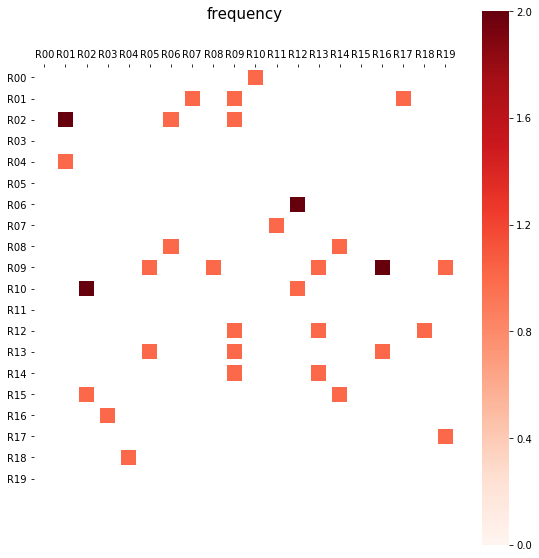

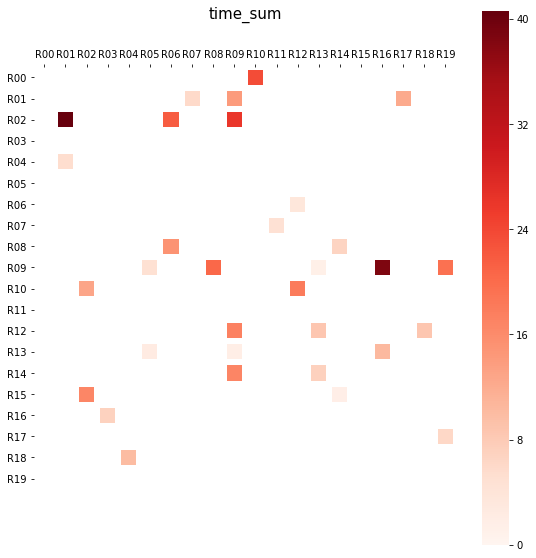

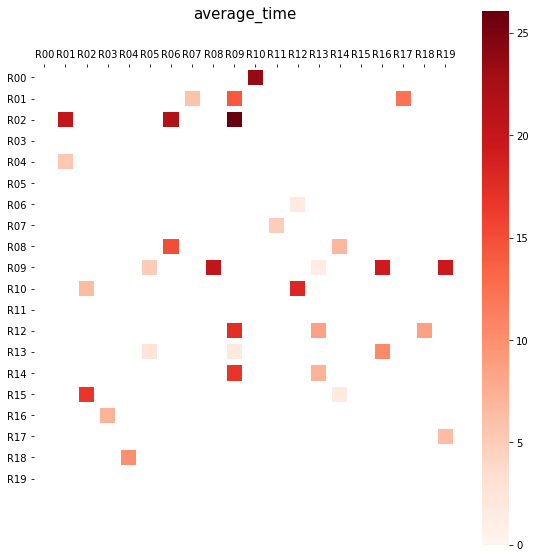

In [552]:
r_columns = sorted(set(df['resource']))

R_R_matrix = {
    'frequency': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns), 
    'time_sum': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns)
}

for g in df.groupby('process'):
    sub_df = g[1].iloc()[1:-1]
    for i in range(0, len(sub_df), 2):
        from_series, to_series = sub_df.iloc()[i], sub_df.iloc()[i+1]
        if from_series.resource != to_series.resource:## 같을 때는 transfer of work이 아님.       
            R_R_matrix['frequency'][from_series.resource][to_series.resource] += 1
            R_R_matrix['time_sum'][from_series.resource][to_series.resource] += (to_series['timestamp'] - from_series['timestamp'])
R_R_matrix['average_time'] = (R_R_matrix['time_sum']/ R_R_matrix['frequency']).fillna(0)
## frequency heatmap 
for k in R_R_matrix.keys():
    plt.figure(figsize=(8, 8))
    sns.heatmap(R_R_matrix[k], cmap=plt.cm.Reds, 
                mask = R_R_matrix[k].applymap(lambda x: False if x!=0 else True), 
                linewidths=5, cbar=True, square=True)
    plt.tick_params(labelsize=10)
    #title_pos = sum(plt.xlim())/2, plt.ylim()[0]
    plt.title(k, position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
    plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

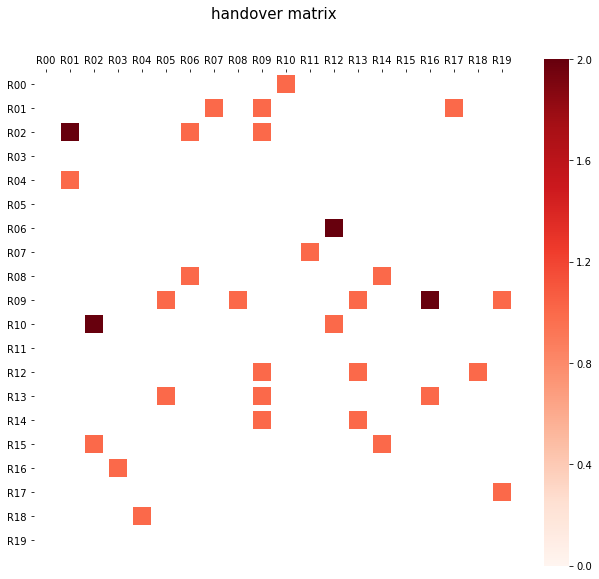

In [553]:
## handover matrix 
plt.figure(figsize=(9, 8))
sns.heatmap(R_R_matrix['frequency'], cmap=plt.cm.Reds, 
            mask = R_R_matrix[k].applymap(lambda x: False if x!=0 else True), 
            linewidths=5, cbar=True, square=True)
plt.tick_params(labelsize=10)
plt.title('handover matrix', position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_handover_matrix.png', dpi=200)
plt.show()

In [555]:
OC_matrix = R_R_matrix['frequency'].copy()
for col in OC_matrix:
    for idx in OC_matrix.index:
        if nx.shortest_path_length(R_net, col, idx)!=1:
            OC_matrix[col][idx]=0

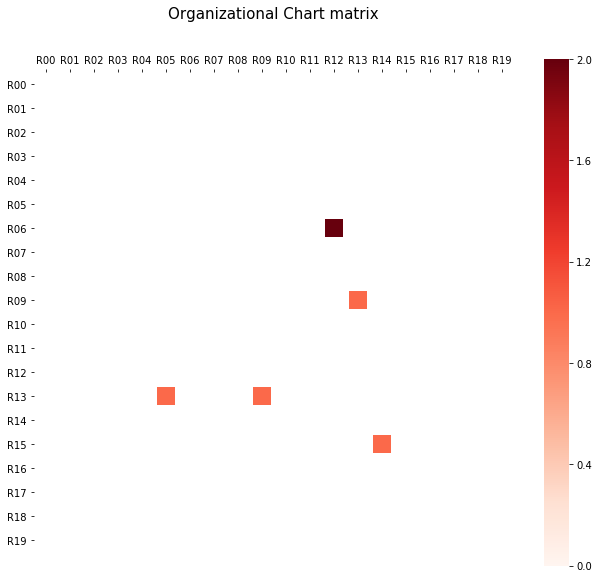

In [556]:
plt.figure(figsize=(9, 8))
sns.heatmap(OC_matrix, cmap=plt.cm.Reds, 
            mask = OC_matrix.applymap(lambda x: False if x!=0 else True), 
            linewidths=5, cbar=True, square=True)
plt.tick_params(labelsize=10)
plt.title('Organizational Chart matrix', position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout(), 
#plt.savefig('../../assets/images/markdown_img/180816_oc_matrix.png', dpi=200)
plt.show()

In [372]:
tempG = R_net.copy()
aa = [n for n in tempG.nodes() if n.name=='R19'][0]
tempG.remove_edges_from([e for e in tempG.edges(data=True) if aa in e])
tempG.add_edge([n for n in tempG.nodes() if n.name=='R19'][0], [n for n in tempG.nodes() if n.name=='R12'][0])